# NIS injection time simulation

## Introduction

The New Injection Systems (NIS) autoinjector does not suffer from some of the limitations of traditional spring-powered autoinjectors, such as a relatively low limit on the force of the main spring. See Springboard document "AAD-00322-revC NIS versus competitors" for more information. 

If the main spring can be stronger, and the needle can be shorter, then the injection time can be shorter for a given drug viscosity.

Looking at it another way, the NIS autoinjector should be able to inject more viscous drugs than competitor devices for a given needle diameter.

This document is a simulation to predict the maximum injection time for a given needle, viscosity and volume.

Currently, this document only considers injection time as the limit on viscosity.  There might be other limits, such as the device failing if the spring force is too high in storage.

## Injection time limit

There is no hard limit to injection time that is accepted in the drug delivery industry.  However, we can summarise the times specified in the Instructions for Use for example drugs on the market:

| Autoinjector | Drug    | Injection time (s)  | Reference |
|:-------------|:--------|:-------------------:|:----------|
| EpiPen       | Epinephrine | 3 | [EpiPen Instructions for Use](https://dailymed.nlm.nih.gov/dailymed/fda/fdaDrugXsl.cfm?setid=7560c201-9246-487c-a13b-6295db04274a&type=display#section-14) |
| SymTouch (Molly)        | Zembrace (Sumatriptan) | 5 | [Zembrance Instructions for Use](http://www.zembrace.com/Content/docs/zembrace-instructions-for-use.pdf)|
| Humira Pen | Humira (adalimumab) | 10 | [Transcript of Humira training video](https://www.humira.com/humira-complete/transcript_adultPen) |
| AutoClicks   | Cimzia (certolizumab pegol) | 15 | [Cimzia AutoClicks Instructions for Use](https://www.medicines.org.uk/emc/files/pil.7387.pdf) |
| DAI (SureClick) | Enbrel (etanercept) | 15 | [Enbrel Instructions for Use](https://www.enbrel.com/-/media/project/enbrel/discussion-guides/enbrel_piu.ashx) |

Ypsomed has [published a study](https://yds.ypsomed.com/files/media/03_Documents/12_Articles/!!20_OnDrugD_SCAN_How%20long%20can%20you%20hold%20the%20device%20against%20the%20skin.pdf) claiming that patients experienced no errors for 30 second injections (although the study did not question whether there was an upper limit set by patient _preference_).
For relatively long injections such as 15 seconds, injection time is dominated by the viscous flow of the drug through the needle, which we can model using the Hagen-Poiseuille equation.

## The Hagen-Poiseuille equation for injection time

The Hagen–Poiseuille equation for flow rate is

\begin{equation*}Q = \frac{\pi \Delta P d^4}{128 \mu L}\end{equation*}

where $\pi$ is 3.141, $\Delta P$ is the pressure drop (Pa), d is the diameter (m), $\mu$ is the dynamic viscosity (Pa.s), and L is the Needle length (m). [Reference: Anaesthesia UK](http://www.frca.co.uk/article.aspx?articleid=100482)

Assuming a constant flow rate, and replacing the pressure with force per unit area of Syringe, the time taken to inject is

\begin{equation*}t = \frac{32 \mu L V D^2}{F d^4}\end{equation*}

where V is the volume injected ($m^3$), D is the Syringe diameter (m), and F is the force on the Syringe plunger (N).

The equation can be extended to two needles in series for different septum and patient needles:

\begin{equation*}t = \frac{32 \mu V d^2}{F} \left(\frac{L_{1}}{D_{1}^4} + \frac{L_{1}}{D_{1}^4}\right) \end{equation*}

Where the subscripts 1 and 2 denote the patient and septum needles.

The injection times must be taken as approximations because:

1. This is only a simulation.

2. The simulation is very sensitive to distributions for which we have little or no actual measurement data. One would need to measure a representative sample of each sensitive parameter across more than one batch to reduce the errors in this simulation.

## Assumptions and limitations

For this simulation, we have assumed the following:

1. The drug formulation is a Newtonian fluid. That is, the viscosity does not vary with shear rate.
1. Needle bore is round.
1. Needle bore is uniform along the Needle length.
1. The flow resistance within the cartridge (as opposed to the Needle) is negligible. That is, we do not need to calculate the Hagen-Poiseuille pressure drop in the cartridge.
1. The glide force (friction) between the Plunger and Cartridge is:
  a. Constant as the Plunger moves along its stroke.
  b. The correct value for the speed at which we are injecting.  In reality, the friction is
     rate-dependent.
  c. Independent of the storage time and conditions.  In practice, there is some dependence.
1. The inputs into the Hagen-Poiseuille equation are independent. For example, we assume that the needle bore does not correlate with the needle length.
1. All parameters for which we do not have actual data are:
 * In control.
 * Centred. That is, the mean of the distribution is on target.
 * Process capable to 4 standard deviations ($c_{p} = 1.33$). 
 
We do not know the degree to which batch-to-batch variation affects the parameters.

In [12]:
# Import standard library modules
from functools import partial

# Import third-party modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual, IntSlider, Dropdown

# Import Springboard modules
import montecarlo as mc

In [13]:
# Set the size for figures (charts)
mpl.rcParams['figure.figsize'] = (10, 8)

In [14]:
# Define the Hagen-Poiseuille equation
def hagen(spring, glide, friction, viscosity, volume, 
          pat_length, pat_needle_dia, sept_length, sept_needle_dia, container_dia):
    """Return the time in seconds taken to propel volume through Needle.
    
    Parameters:
    spring:       injection spring force (N).
    glide:        friction (N) between the Plunger and Syringe.
    friction:     friction in the device, typically between the 
                  Plunger Rod and Body.
    viscosity:    viscosity (cP) of the liquid.
    volume:       liquid volume (mL) to pass through the Needle.
    pat_length:   length (mm) of patient Needle through which liquid flows.
                  Note that this is often greater than the exposed 
                  length of Needle.
    pat_needle_dia:   inner diameter (mm) of patient needle diameter.
    sept_length:   length (mm) of septum Needle through which liquid flows.
                  Note that this is often greater than the exposed 
                  length of Needle.
    sept_needle_dia:   inner diameter (mm) of septum needle diameter.
    container_dia:inner diameter (mm) of Syringe.
    """
    # Find the force on the liquid
    force = spring - glide - friction
    return (0.000032 * viscosity * volume * (container_dia ** 2)) * \
            ((pat_length / (pat_needle_dia ** 4)) + (sept_length / (sept_needle_dia ** 4)))            \
        / force 

# Test the hagen function
tolerance = 0.01  # Assert equal to 2 decimal places

tests = (
    {'expected': 5.04907, 'actual': hagen(40, 2, 1.2, 50, 0.9, 6.25, 0.25,6.25, 0.25, 6.35)},
    {'expected': 14.7673, 'actual': hagen(40, 4, 2, 80, 1, 9.5, 0.25,9.5, 0.25, 6.35)},
    {'expected': 13.5451, 'actual': hagen(50, 4, 2, 10, 2, 8, 0.20,8, 0.20, 9.65)},
)

for test in tests:
    try:
        assert abs(test['expected'] - test['actual']) < tolerance
    
    except AssertionError:
        print(f"Error: {test['expected']} != {test['actual']}")

# Forces in the device

There are three forces present in the device: the force from the compression of the spring, the device friction and the plunger-cartridge wall friction.

### Spring force

Note: we need to consider the maximum force we are willing to use before the spring becomes an unacceptable risk to put in an autoinjector.  
3-month stability testing at Boehringer Ingelheim used 75 N springs.  
EpiPen uses 87 N [Jaguar.AFQ\60. Analysis\Spring design\AFQ-00025-revA Max spring force designs.xlsx]

The forces discussed above are the maximum force when the spring is compressed in manufacture.  Be careful to use the spring force at the start of injection, not when the spring is at its solid length, or at the start of needle insertion (if the spring powers the needle insertion).

The force we need to use for injection time calculations is the mean force, also called the midway force because it is the force
that the spring exerts midway through the injection.

Here we use spring designs from "Sales.AAD\Clients\Midas Pharma\2019-11 Design for terminal sterilisation\AAD-00323-revC NIS dimensions and springs.xlsx"

Use a standard spring manufacturing tolerance of $\pm$10%.

[Axcess Spring](https://www.thespringstore.com/standard-spring-rate-tolerance.html) and [Lee Spring](https://www.leespring.com/engineering-notes-and-tolerances) quote this industry standard 10% tolerance on spring rate.

### Device friction

All devices have internal friction between some components.  Friction tolerances are very difficult to define.  We can expect that they are 
not tight because they are not parameters that can be controlled directly in manufacturing
processes unlike a dimension. We can also expect that they scale with the mean friction 
(larger mean friction will have a larger absolute tolerance), and that friction cannot
be negative.

Therefore, let us set all friction tolerances to be $\pm$ 70%.

### Plunger-cartridge friction

Let us use 0.54 N (see AFQ-00010-revA Plunger friction analysis from project Jaguar).

In [15]:
def define_force_distributions(nom_device_friction, nom_plunger_friction, nom_spring_force):
    device_friction = mc.Parameter(nom_device_friction, 0.7 * nom_device_friction)
    plunger_friction = mc.Parameter(nom_plunger_friction, 0.7 * nom_plunger_friction)
    spring_force = mc.Parameter(nom_spring_force, nom_spring_force * 0.1,'Midway spring force')
    return spring_force, device_friction, plunger_friction 
    # Spring for 1.5 mL cartridge

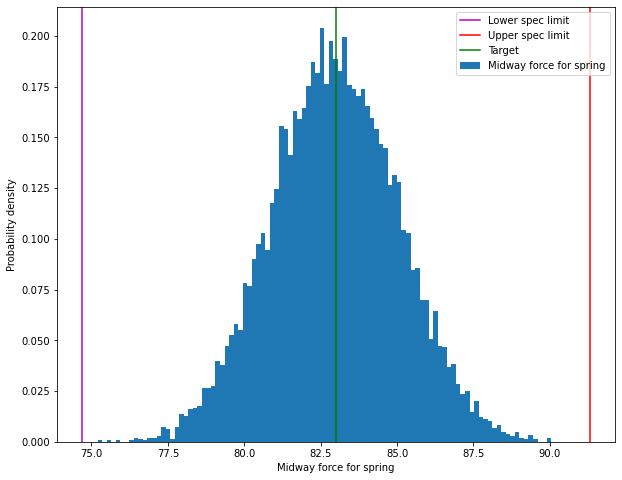

In [16]:
#Example distribution
spring_1_5 = mc.Parameter(83, 0.1 * 83, 'Midway force for spring')
spring_1_5.hist();

# Needle lengths

[ISO 7864:2016](https://www.iso.org/standard/60481.html) specifies a tolerance on needle length of +1mm, -2mm so a tolerance of ±1 mm will be assumed.

In [17]:
def define_needle_length_distributions(nom_pat_needle_length, nom_sept_needle_length):
    pat_needle_length = mc.Parameter(nom_pat_needle_length,1)
    sept_needle_length = mc.Parameter(nom_sept_needle_length,1)
    return pat_needle_length, sept_needle_length


# Cartridge configurations

#### Drug formulation volume to be injected

Midas has proposed using a 1.0 mL fill in 1.5 mL cartridge and 2.0 mL fill volume in a 3 mL cartridge.

A typical tolerance on volume fill might be $\pm$ 0.05 mL [ABH-00083-revF].

A tolerance of $\pm$1% for fill volume is usually achieved for cartridge filling according to [Bausch Group](https://www.bausch-group.com/) however it may depend on the drug viscosity and surface tension.

#### Cartridge inner diameter

The ISO standards for container diameters are:

| Container type | Inner diameter (mm) | Reference |
|---|---|---|
| 1 mL "BD Hypak long" syringe | 6.35 $\pm$ 0.1 | Hypak and Neopak drawings |
| 1 mL cartridge | 6.85 $\pm$ 0.1 | [ISO 13926-1:2004](https://www.iso.org/standard/40331.html)|
| 1.5 mL cartridge | 6.85 $\pm$ 0.1 | [ISO 13926-1:2004](https://www.iso.org/standard/40331.html) and [Ypsomed drawing](https://yds.ypsomed.com/en/injection-systems/pen-injectors/unopen.html) |
| 3.0 mL cartridge | 9.65 $\pm$ 0.1 | [ISO 13926-1:2004](https://www.iso.org/standard/40331.html) and [Ypsomed drawing](https://yds.ypsomed.com/en/injection-systems/pen-injectors/unopen.html)|

In [26]:
cartridge_configs = pd.read_excel('Cartridge configurations.xlsx', index_col=0, engine='openpyxl')

def define_cartridge_config_distributions(config):
    volume = cartridge_configs['Volume (mL)'][config]
    volumes = mc.Parameter(volume, 0.05)
    cartridge_diameter = cartridge_configs['Cartridge ID (mm)'][config]
    cartridge_diameters = mc.Parameter(cartridge_diameter, 0.1)
    return volumes, cartridge_diameters
    

## Needle diameters

For reference, EpiPen uses a [22 gauge needle](http://www.epipen.co.uk/hcp/faqs/) and Cimzia AutoClicks uses a 25 gauge thin wall needle.

We can analyse needle diameters from 31 gauge (around the smallest used outside low-depth insulin injections) up to 25 gauge (the largest in modern autoinjector use).

The staked needles in syringes tend to be odd gauge numbers (25, 27, 29) so we shall model these and there is not much benefit in modelling the even numbers in addition.

Thin walled needles can be used, but we use a regular wall for the 31 gauge needle because it is becoming very thin for the needle length.

Needle sizes can be found on the [Sigma Aldrich](https://www.sigmaaldrich.com/assets/documents/Supelco/Application_Notes/syringes5.pdf) website.

In [19]:
needle_types = pd.read_excel('Needle diameters.xlsx', usecols="A:F", index_col=0, engine='openpyxl')
needle_types

,Wall,Min_ID_ISO,Min_ID,Nominal_ID,Max_ID
Gauge,,,,,
31,RW,0.125,0.1143,0.13462,0.1524
29,TW,0.190,0.2032,0.21590,0.2286
27,TW,0.241,0.2400,0.25000,0.2800
25,TW,0.292,0.2900,0.31000,0.3300
24,TW,0.343,0.3400,0.37000,0.3900
23,TW,0.370,0.4200,0.43000,0.4600
22,TW,0.440,0.4800,0.51000,0.5200
21,TW,0.547,0.5700,0.58000,0.6100
20,TW,0.635,0.6500,0.66000,0.6900


In [23]:
def define_needle_diameter_distributions(needle_gauges):
    needle_IDs = []
    for gauge in needle_gauges:
        nominal_ID = needle_types['Nominal_ID'][gauge]
        tolerance = needle_types['Nominal_ID'][gauge]-needle_types['Min_ID'][gauge]
        needle_IDs.append(mc.Parameter(nominal_ID, tolerance, gauge))
    return needle_IDs

## Drug forumulation viscosity

Let us model a range of viscosities with an arbitrary tolerance of $\pm$10%.

In [24]:
viscosities = [mc.Parameter(v, 0.1 * v) for v in (1, 10, 30, 50, 70, 100)]
viscosities

[Parameter(1.00),
 Parameter(10.00),
 Parameter(30.00),
 Parameter(50.00),
 Parameter(70.00),
 Parameter(100.00)]

## Example Monte Carlo simulation

Create a distribution of needle diameters for the 25 gauge thin wall needle.

In [27]:
#Define distributions
spring, glide, friction = define_force_distributions(1,0.46,70)
patient_needle_length, septum_needle_length = define_needle_length_distributions(10, 10)
septum_needle_diameter = define_needle_diameter_distributions([22])
patient_needle_diameters = define_needle_diameter_distributions([29])
volumes, cartridge_diameters = define_cartridge_config_distributions('1 mL fill in 1 mL cartridge')

# Calculate injection times at room temperature
# The rvs property is the 'random variates' (the distribution as an array)

times = hagen(spring.rvs, friction.rvs, glide.rvs, viscosities[4].rvs,
              volumes.rvs, patient_needle_length.rvs, patient_needle_diameters[0].rvs, 
              septum_needle_length.rvs, septum_needle_diameter[0].rvs, cartridge_diameters.rvs)



In [28]:
#  Set upper specification limit for injection time
TIME_USL = 15  # seconds

Median (seconds)                7.288594
Mean (seconds)                  7.309952
Standard deviation (seconds)    0.541198
ppm above 15 seconds            0.000000
dtype: float64

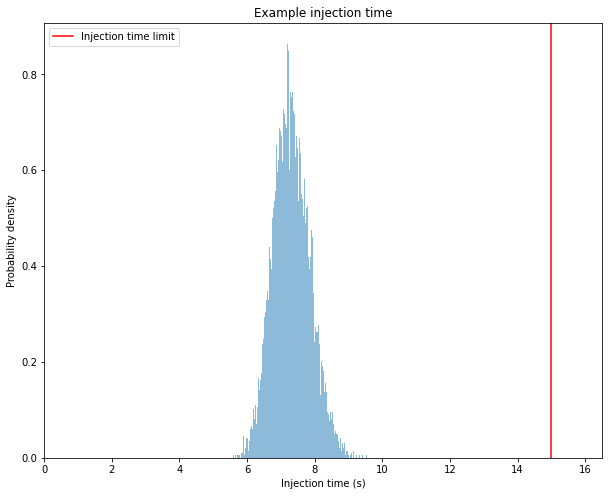

In [29]:
def plot_times(*times, **kwargs):
    """Plot histograms of one or more time distributions.
    
    Parameters:
    times are the arrays of injection times
    kwargs are the keyword argments to set on the axes
    
    Returns: plot axes
    """
    figure, axes = plt.subplots()

    for time_ in times:
        # Create histogram of injection times with 200 bins, 
        # and normalised (density plot = True)
        axes.hist(time_, bins=200, density=True, alpha=0.5)
    
    axes.set(xlabel='Injection time (s)', ylabel='Probability density')
    axes.set_xlim(0, 1.1 * TIME_USL)
    axes.axvline(TIME_USL, color='r', label='Injection time limit')
    axes.legend()
    axes.set(**kwargs)
    return axes


# Plot and describe the injection times
plot_times(times, title=f"Example injection time")

# Print ppm above or below time limits
mc.describe(times, units='seconds', usl=TIME_USL)

## Calculate and plot injection times for different needles and drug viscosities

In [30]:
# Use this plotting function to set format and style for plot
def plot_grid(df, **kwargs):
    """Plot the DataFrame df and set the keyword argments kwargs on the axes."""
    axes = df.plot()
    axes.set(**kwargs)
    """Mark injection time area that does not meet 15s requirement."""
    #axes.axhspan(15,df.to_numpy().max(), color='red', alpha=0.1)
    plt.xlim([0, df.index.max()])
    plt.ylim([0, min(df.to_numpy().max(),60)])
    axes.grid();

In [32]:
style = {'description_width': 'initial','width': '900px'}
@interact
def plot_injection_times(nom_pat_needle_length = IntSlider(description = 'Patient needle length (mm):', min=5,max=20,value=10,style=style,continuous_update=False),
                         nom_sept_needle_length = IntSlider(description = 'Septum needle length (mm):', min=5,max=30,value=17,style=style,continuous_update=False),
                         septum_needle_gauge = Dropdown(options=needle_types.index.values,style=style,value=22, description = 'Septum needle gauge:'),
                         percentile = IntSlider(description = 'Percentile (%):', min=1,max=99,value=99,style=style,continuous_update=False),
                        nom_spring_force = IntSlider(description = 'Spring Force (N):', min=5,max=150,value=50,style=style,continuous_update=False),
                        cartridge_configuration = Dropdown(description= 'Cartridge configuration:',options=cartridge_configs.index.values,style=style)):
                         
    #get distributions from each variable             
    spring, glide, friction = define_force_distributions(1.4,0.54,nom_spring_force)
    patient_needle_length, septum_needle_length = define_needle_length_distributions(nom_pat_needle_length, nom_sept_needle_length)
    septum_needle_diameter = define_needle_diameter_distributions([septum_needle_gauge])
    patient_needle_diameters = define_needle_diameter_distributions([25,27,29,31])
    volumes, cartridge_diameters = define_cartridge_config_distributions(cartridge_configuration)

    # List of dictionaries to store distributions of times
    times = []

    for viscosity in viscosities:
        time_ = {}

        for patient_needle in patient_needle_diameters:
            
            time_[patient_needle.name] = hagen(spring.rvs, friction.rvs, glide.rvs, viscosity.rvs,
                                        volumes.rvs, patient_needle_length.rvs, patient_needle.rvs, 
                                       septum_needle_length.rvs, septum_needle_diameter[0].rvs, cartridge_diameters.rvs)
        times.append(time_)

    inj_times = pd.DataFrame(times, index=(v.target for v in viscosities))
    
    #Using quantiles to find percentile
    quantile = partial(np.quantile, q=percentile/100)
    max_inj_time = inj_times.applymap(quantile)
    
    
    
    plot_grid(max_inj_time,
     title=str(percentile)+'% of injection times for '+str(cartridge_configuration),
     ylabel='Injection time (s)',
     xlabel='Viscosity (cP)')
    


interactive(children=(IntSlider(value=10, continuous_update=False, description='Patient needle length (mm):', …

#### Design Parameters
Design AAD-00474-revB NIS ASSEMBLY PACKAGED has the following design parameters:
- Septum needle length: 17.5 mm
- Septum needle gauge: 22 (Thin wall)
- Patient needle length: 10.3 mm
- Patient needle gauge: 31 (Regular wall)
    

## Conclusions


## Revisions

This document is AIJ-00005, and the revision levels are:

| Revision | Date       | Author           | Changes |
|----------|------------|:-----------------|:--------|
| A1       | 2021-11-21 | Tom Oakley       | First draft |
| A2       | 2021-11-23 | Hamish Atkins    | Updated to include septum needle and interactivity |